In [1]:
import os
import pandas as pd
import backtrader as bt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('/home/adedapo/personal_project/daps05ayoade/disseration')
from algotrading.strategy.data_fetcher import DataFetcher
from algotrading.secrecy import API_TOKEN
%matplotlib inline

# Learning Backtesting

In [2]:
# import pandas as pd
# import yfinance as yf
# import ta
# from backtesting import Backtest, Strategy
# from backtesting.lib import crossover

In [3]:
# class SMAcross(Strategy):
    
#     n1 = 50
#     n2 = 200
    
#     def init(self):
#         close = self.data.Close
#         self.sma1 = self.I(ta.trend.sma_indicator, pd.Series(close), self.n1)
#         self.sma2 = self.I(ta.trend.sma_indicator, pd.Series(close), self.n2)
        
#     def next(self):
#         if crossover(self.sma1, self.sma2):
#             self.buy()
#         elif crossover(self.sma2, self.sma1):
#             self.sell()

In [4]:
# df = yf.download('AAPL', start='2018-01-01')

In [5]:
# bt = Backtest(df, SMAcross, cash=100000, commission=0.002,
#              exclusive_orders=True)

In [6]:
# output = bt.run()

In [7]:
# output

In [8]:
# optim = bt.optimize(n1 = range(50,160,10),
#                    n2 = range(50,160,10),
#                    constraint= lambda x: x.n2 - x.n1 > 20,
#                    maximize= 'Return [%]')

# bt.plot()

In [9]:
# optim

# Create Trading Strategy

In [10]:
# # Instantiate the data fetcher
# data_fetcher = DataFetcher(API_TOKEN)

# tickers = ["AAPL"]

# # Create data feeds
# datafeeds = {}
# for ticker in tickers:
#     api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={ticker}&outputsize=full&apikey={API_TOKEN}'
#     data = data_fetcher.get_data_from_url(api_url)
#     if 'Time Series (Daily)' not in data:
#         raise ValueError("Time Series (Daily) data not found in response.")

#     data = pd.DataFrame(data['Time Series (Daily)']).T
#     data.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume', 'dividend_amount', 'split_coeff']
#     data.columns = data.columns.str.lower()
#     data.index = pd.to_datetime(data.index)

#     # Convert columns to float
#     for col in ['open', 'high', 'low', 'close', 'adj_close', 'volume', 'dividend_amount']:
#         data[col] = data[col].astype(float)

#     data = data.sort_index(ascending=True)
#     data.drop(columns=['split_coeff'], inplace=True)
#     data.dropna(inplace=True)

In [11]:
# Add data feed to Cerebro
data = yf.download('AAPL', start='2020-01-01')

[*********************100%***********************]  1 of 1 completed


## SMA Crossover

In [12]:
# Instantiate Cerebro engine
cerebro = bt.Cerebro()

# Convert the DataFrame to a Backtrader data feed and store it in the dictionary
datafeeds = bt.feeds.PandasData(dataname=data)

cerebro.adddata(datafeeds, name='AAPL')

class SMACrossoverStrategy(bt.Strategy):
    params = (
        ('short_term_period', 50),
        ('long_term_period', 200),
    )

    def log(self, txt, dt=None):
        dt = dt or self.data.datetime[0]
        dt = bt.num2date(dt)
        print(f'{dt.isoformat()}, {txt}')

    def __init__(self):
        self.sma_short = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.short_term_period)
        self.sma_long = bt.indicators.SimpleMovingAverage(
            self.data.close, period=self.params.long_term_period)

        self.crossover = bt.indicators.CrossOver(self.sma_short, self.sma_long)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    f'BUY EXECUTED, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Comm {order.executed.comm:.2f}')
            else:  # Sell
                self.log(
                    f'SELL EXECUTED, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Comm {order.executed.comm:.2f}')

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

    def next(self):
        if not self.position:  # not in the market
            if self.crossover > 0:  # if fast crosses slow to the upside
                self.log('BUY CREATE, %.2f' % self.data.close[0])
                self.order = self.buy()  # enter long

        elif self.crossover < 0:  # in the market & cross to the downside
            self.log('SELL CREATE, %.2f' % self.data.close[0])
            self.order = self.sell()  # close long position

In [13]:
# Add strategy
cerebro.addstrategy(SMACrossoverStrategy)
cerebro.broker.setcash(10000.0)

In [14]:
# Run the backtest
test = cerebro.run()

2022-09-28T00:00:00, BUY CREATE, 149.84
2022-09-29T00:00:00, BUY EXECUTED, Price: 146.10, Cost: 146.10, Comm 0.00
2022-09-30T00:00:00, SELL CREATE, 138.20
2022-10-03T00:00:00, SELL EXECUTED, Price: 138.21, Cost: 146.10, Comm 0.00
2023-03-23T00:00:00, BUY CREATE, 158.93
2023-03-24T00:00:00, BUY EXECUTED, Price: 158.86, Cost: 158.86, Comm 0.00


### Optimisng SMA

In [16]:
# Parameter ranges
short_term_period_range = range(10, 50, 5) # Fast SMA period, increment by 5
long_term_period_range = range(50, 200, 10) # Slow SMA period, increment by 10

# Run optimization
cerebro.optstrategy(
    SMACrossoverStrategy,
    short_term_period=short_term_period_range,
    long_term_period=long_term_period_range,
)

# Add an analyzer
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')

# Run Cerebro
results = cerebro.run(maxcpus=1)

# Get optimal parameters
optimal_params = None
highest_total_return = -1

for run in results:
    for res in run:
        total_return = res.analyzers.returns.get_analysis()['rtot']  # total return
        print(f"Total return for params short_term_period={res.params.short_term_period}, long_term_period={res.params.long_term_period}: {total_return}")
        if total_return > highest_total_return:
            print(f"New highest return found: {total_return}")
            highest_total_return = total_return
            optimal_params = res.params

print(f'Optimal parameters: short_term_period={optimal_params.short_term_period}, long_term_period={optimal_params.long_term_period}')

2020-04-22T00:00:00, BUY CREATE, 69.03
2020-04-23T00:00:00, BUY EXECUTED, Price: 68.97, Cost: 68.97, Comm 0.00
2020-09-24T00:00:00, SELL CREATE, 108.22
2020-09-25T00:00:00, SELL EXECUTED, Price: 108.43, Cost: 68.97, Comm 0.00
2020-10-13T00:00:00, BUY CREATE, 121.10
2020-10-14T00:00:00, BUY EXECUTED, Price: 121.00, Cost: 121.00, Comm 0.00
2020-10-27T00:00:00, SELL CREATE, 116.60
2020-10-28T00:00:00, SELL EXECUTED, Price: 115.05, Cost: 121.00, Comm 0.00
2020-11-12T00:00:00, BUY CREATE, 119.21
2020-11-13T00:00:00, BUY EXECUTED, Price: 119.44, Cost: 119.44, Comm 0.00
2021-02-23T00:00:00, SELL CREATE, 125.86
2021-02-24T00:00:00, SELL EXECUTED, Price: 124.94, Cost: 119.44, Comm 0.00
2021-04-13T00:00:00, BUY CREATE, 134.43
2021-04-14T00:00:00, BUY EXECUTED, Price: 134.94, Cost: 134.94, Comm 0.00
2021-05-17T00:00:00, SELL CREATE, 126.27
2021-05-18T00:00:00, SELL EXECUTED, Price: 126.56, Cost: 134.94, Comm 0.00
2021-06-21T00:00:00, BUY CREATE, 132.30
2021-06-22T00:00:00, BUY EXECUTED, Price: 13

2021-04-14T00:00:00, BUY CREATE, 132.03
2021-04-15T00:00:00, BUY EXECUTED, Price: 133.82, Cost: 133.82, Comm 0.00
2021-05-12T00:00:00, SELL CREATE, 122.77
2021-05-13T00:00:00, SELL EXECUTED, Price: 124.58, Cost: 133.82, Comm 0.00
2021-06-16T00:00:00, BUY CREATE, 130.15
2021-06-17T00:00:00, BUY EXECUTED, Price: 129.80, Cost: 129.80, Comm 0.00
2021-10-07T00:00:00, SELL CREATE, 143.29
2021-10-08T00:00:00, SELL EXECUTED, Price: 144.03, Cost: 129.80, Comm 0.00
2021-10-21T00:00:00, BUY CREATE, 149.48
2021-10-22T00:00:00, BUY EXECUTED, Price: 149.69, Cost: 149.69, Comm 0.00
2022-03-02T00:00:00, SELL CREATE, 166.56
2022-03-03T00:00:00, SELL EXECUTED, Price: 168.47, Cost: 149.69, Comm 0.00
2022-03-29T00:00:00, BUY CREATE, 178.96
2022-03-30T00:00:00, BUY EXECUTED, Price: 178.55, Cost: 178.55, Comm 0.00
2022-04-19T00:00:00, SELL CREATE, 167.40
2022-04-20T00:00:00, SELL EXECUTED, Price: 168.76, Cost: 178.55, Comm 0.00
2022-07-29T00:00:00, BUY CREATE, 162.51
2022-08-01T00:00:00, BUY EXECUTED, Price

2022-03-17T00:00:00, SELL CREATE, 160.62
2022-03-18T00:00:00, SELL EXECUTED, Price: 160.51, Cost: 130.37, Comm 0.00
2022-03-21T00:00:00, BUY CREATE, 165.38
2022-03-22T00:00:00, BUY EXECUTED, Price: 165.51, Cost: 165.51, Comm 0.00
2022-05-02T00:00:00, SELL CREATE, 157.96
2022-05-03T00:00:00, SELL EXECUTED, Price: 158.15, Cost: 165.51, Comm 0.00
2022-08-05T00:00:00, BUY CREATE, 165.35
2022-08-08T00:00:00, BUY EXECUTED, Price: 166.37, Cost: 166.37, Comm 0.00
2022-09-09T00:00:00, SELL CREATE, 157.37
2022-09-12T00:00:00, SELL EXECUTED, Price: 159.59, Cost: 166.37, Comm 0.00
2022-09-28T00:00:00, BUY CREATE, 149.84
2022-09-29T00:00:00, BUY EXECUTED, Price: 146.10, Cost: 146.10, Comm 0.00
2022-09-30T00:00:00, SELL CREATE, 138.20
2022-10-03T00:00:00, SELL EXECUTED, Price: 138.21, Cost: 146.10, Comm 0.00
2023-02-08T00:00:00, BUY CREATE, 151.92
2023-02-09T00:00:00, BUY EXECUTED, Price: 153.78, Cost: 153.78, Comm 0.00
2023-03-03T00:00:00, SELL CREATE, 151.03
2023-03-06T00:00:00, SELL EXECUTED, Pri

2020-05-08T00:00:00, BUY CREATE, 77.53
2020-05-11T00:00:00, BUY EXECUTED, Price: 77.03, Cost: 77.03, Comm 0.00
2021-03-04T00:00:00, SELL CREATE, 120.13
2021-03-05T00:00:00, SELL EXECUTED, Price: 120.98, Cost: 77.03, Comm 0.00
2021-04-20T00:00:00, BUY CREATE, 133.11
2021-04-21T00:00:00, BUY EXECUTED, Price: 132.36, Cost: 132.36, Comm 0.00
2021-05-18T00:00:00, SELL CREATE, 124.85
2021-05-19T00:00:00, SELL EXECUTED, Price: 123.16, Cost: 132.36, Comm 0.00
2021-06-16T00:00:00, BUY CREATE, 130.15
2021-06-17T00:00:00, BUY EXECUTED, Price: 129.80, Cost: 129.80, Comm 0.00
2021-10-05T00:00:00, SELL CREATE, 141.11
2021-10-06T00:00:00, SELL EXECUTED, Price: 139.47, Cost: 129.80, Comm 0.00
2021-11-01T00:00:00, BUY CREATE, 148.96
2021-11-02T00:00:00, BUY EXECUTED, Price: 148.66, Cost: 148.66, Comm 0.00
2022-03-02T00:00:00, SELL CREATE, 166.56
2022-03-03T00:00:00, SELL EXECUTED, Price: 168.47, Cost: 148.66, Comm 0.00
2022-04-04T00:00:00, BUY CREATE, 178.44
2022-04-05T00:00:00, BUY EXECUTED, Price: 17

2023-02-14T00:00:00, BUY CREATE, 153.20
2023-02-15T00:00:00, BUY EXECUTED, Price: 153.11, Cost: 153.11, Comm 0.00
2021-04-09T00:00:00, BUY CREATE, 133.00
2021-04-12T00:00:00, BUY EXECUTED, Price: 132.52, Cost: 132.52, Comm 0.00
2021-05-28T00:00:00, SELL CREATE, 124.61
2021-06-01T00:00:00, SELL EXECUTED, Price: 125.08, Cost: 132.52, Comm 0.00
2021-06-16T00:00:00, BUY CREATE, 130.15
2021-06-17T00:00:00, BUY EXECUTED, Price: 129.80, Cost: 129.80, Comm 0.00
2022-05-05T00:00:00, SELL CREATE, 156.77
2022-05-06T00:00:00, SELL EXECUTED, Price: 156.01, Cost: 129.80, Comm 0.00
2022-08-10T00:00:00, BUY CREATE, 169.24
2022-08-11T00:00:00, BUY EXECUTED, Price: 170.06, Cost: 170.06, Comm 0.00
2022-09-15T00:00:00, SELL CREATE, 152.37
2022-09-16T00:00:00, SELL EXECUTED, Price: 151.21, Cost: 170.06, Comm 0.00
2022-09-28T00:00:00, BUY CREATE, 149.84
2022-09-29T00:00:00, BUY EXECUTED, Price: 146.10, Cost: 146.10, Comm 0.00
2022-09-30T00:00:00, SELL CREATE, 138.20
2022-10-03T00:00:00, SELL EXECUTED, Price

2020-05-11T00:00:00, BUY CREATE, 78.75
2020-05-12T00:00:00, BUY EXECUTED, Price: 79.46, Cost: 79.46, Comm 0.00
2020-11-19T00:00:00, SELL CREATE, 118.64
2020-11-20T00:00:00, SELL EXECUTED, Price: 118.64, Cost: 79.46, Comm 0.00
2020-11-30T00:00:00, BUY CREATE, 119.05
2020-12-01T00:00:00, BUY EXECUTED, Price: 121.01, Cost: 121.01, Comm 0.00
2021-03-09T00:00:00, SELL CREATE, 121.09
2021-03-10T00:00:00, SELL EXECUTED, Price: 121.69, Cost: 121.01, Comm 0.00
2021-04-23T00:00:00, BUY CREATE, 134.32
2021-04-26T00:00:00, BUY EXECUTED, Price: 134.83, Cost: 134.83, Comm 0.00
2021-05-26T00:00:00, SELL CREATE, 126.85
2021-05-27T00:00:00, SELL EXECUTED, Price: 126.44, Cost: 134.83, Comm 0.00
2021-06-17T00:00:00, BUY CREATE, 131.79
2021-06-18T00:00:00, BUY EXECUTED, Price: 130.71, Cost: 130.71, Comm 0.00
2021-10-07T00:00:00, SELL CREATE, 143.29
2021-10-08T00:00:00, SELL EXECUTED, Price: 144.03, Cost: 130.71, Comm 0.00
2021-11-04T00:00:00, BUY CREATE, 150.96
2021-11-05T00:00:00, BUY EXECUTED, Price: 15

2023-02-16T00:00:00, BUY CREATE, 153.71
2023-02-17T00:00:00, BUY EXECUTED, Price: 152.35, Cost: 152.35, Comm 0.00
2021-04-08T00:00:00, BUY CREATE, 130.36
2021-04-09T00:00:00, BUY EXECUTED, Price: 129.80, Cost: 129.80, Comm 0.00
2021-06-01T00:00:00, SELL CREATE, 124.28
2021-06-02T00:00:00, SELL EXECUTED, Price: 124.28, Cost: 129.80, Comm 0.00
2021-06-23T00:00:00, BUY CREATE, 133.70
2021-06-24T00:00:00, BUY EXECUTED, Price: 134.45, Cost: 134.45, Comm 0.00
2022-05-06T00:00:00, SELL CREATE, 157.28
2022-05-09T00:00:00, SELL EXECUTED, Price: 154.93, Cost: 134.45, Comm 0.00
2022-08-11T00:00:00, BUY CREATE, 168.49
2022-08-12T00:00:00, BUY EXECUTED, Price: 169.82, Cost: 169.82, Comm 0.00
2022-09-23T00:00:00, SELL CREATE, 150.43
2022-09-26T00:00:00, SELL EXECUTED, Price: 149.66, Cost: 169.82, Comm 0.00
2022-09-28T00:00:00, BUY CREATE, 149.84
2022-09-29T00:00:00, BUY EXECUTED, Price: 146.10, Cost: 146.10, Comm 0.00
2022-09-30T00:00:00, SELL CREATE, 138.20
2022-10-03T00:00:00, SELL EXECUTED, Price

2022-12-13T00:00:00, BUY CREATE, 145.47
2022-12-14T00:00:00, BUY EXECUTED, Price: 145.35, Cost: 145.35, Comm 0.00
2022-12-20T00:00:00, SELL CREATE, 132.30
2022-12-21T00:00:00, SELL EXECUTED, Price: 132.98, Cost: 145.35, Comm 0.00
2023-02-09T00:00:00, BUY CREATE, 150.87
2023-02-10T00:00:00, BUY EXECUTED, Price: 149.46, Cost: 149.46, Comm 0.00
2020-05-11T00:00:00, BUY CREATE, 78.75
2020-05-12T00:00:00, BUY EXECUTED, Price: 79.46, Cost: 79.46, Comm 0.00
2020-11-09T00:00:00, SELL CREATE, 116.32
2020-11-10T00:00:00, SELL EXECUTED, Price: 115.55, Cost: 79.46, Comm 0.00
2020-11-11T00:00:00, BUY CREATE, 119.49
2020-11-12T00:00:00, BUY EXECUTED, Price: 119.62, Cost: 119.62, Comm 0.00
2020-11-16T00:00:00, SELL CREATE, 120.30
2020-11-17T00:00:00, SELL EXECUTED, Price: 119.55, Cost: 119.62, Comm 0.00
2020-12-03T00:00:00, BUY CREATE, 122.94
2020-12-04T00:00:00, BUY EXECUTED, Price: 122.60, Cost: 122.60, Comm 0.00
2021-03-09T00:00:00, SELL CREATE, 121.09
2021-03-10T00:00:00, SELL EXECUTED, Price: 12

2022-08-12T00:00:00, BUY CREATE, 172.10
2022-08-15T00:00:00, BUY EXECUTED, Price: 171.52, Cost: 171.52, Comm 0.00
2022-09-30T00:00:00, SELL CREATE, 138.20
2022-09-30T00:00:00, SELL CREATE, 138.20
2022-10-03T00:00:00, SELL EXECUTED, Price: 138.21, Cost: 171.52, Comm 0.00
2022-10-03T00:00:00, SELL EXECUTED, Price: 138.21, Cost: -138.21, Comm 0.00
2021-04-13T00:00:00, BUY CREATE, 134.43
2021-04-14T00:00:00, BUY EXECUTED, Price: 134.94, Cost: 134.94, Comm 0.00
2021-06-02T00:00:00, SELL CREATE, 125.06
2021-06-03T00:00:00, SELL EXECUTED, Price: 124.68, Cost: 134.94, Comm 0.00
2021-06-29T00:00:00, BUY CREATE, 136.33
2021-06-30T00:00:00, BUY EXECUTED, Price: 136.17, Cost: 136.17, Comm 0.00
2022-05-09T00:00:00, SELL CREATE, 152.06
2022-05-10T00:00:00, SELL EXECUTED, Price: 155.52, Cost: 136.17, Comm 0.00
2022-08-15T00:00:00, BUY CREATE, 173.19
2022-08-16T00:00:00, BUY EXECUTED, Price: 172.78, Cost: 172.78, Comm 0.00
2022-09-29T00:00:00, SELL CREATE, 142.48
2022-09-30T00:00:00, SELL EXECUTED, Pr

2020-05-14T00:00:00, BUY CREATE, 77.39
2020-05-15T00:00:00, BUY EXECUTED, Price: 75.09, Cost: 75.09, Comm 0.00
2020-11-06T00:00:00, SELL CREATE, 118.69
2020-11-09T00:00:00, SELL EXECUTED, Price: 120.50, Cost: 75.09, Comm 0.00
2020-12-04T00:00:00, BUY CREATE, 122.25
2020-12-07T00:00:00, BUY EXECUTED, Price: 122.31, Cost: 122.31, Comm 0.00
2021-03-11T00:00:00, SELL CREATE, 121.96
2021-03-12T00:00:00, SELL EXECUTED, Price: 120.40, Cost: 122.31, Comm 0.00
2021-05-04T00:00:00, BUY CREATE, 127.85
2021-05-05T00:00:00, BUY EXECUTED, Price: 129.20, Cost: 129.20, Comm 0.00
2021-06-14T00:00:00, SELL CREATE, 130.48
2021-06-15T00:00:00, SELL EXECUTED, Price: 129.94, Cost: 129.20, Comm 0.00
2021-06-30T00:00:00, BUY CREATE, 136.96
2021-07-01T00:00:00, BUY EXECUTED, Price: 136.60, Cost: 136.60, Comm 0.00
2021-10-12T00:00:00, SELL CREATE, 141.51
2021-10-13T00:00:00, SELL EXECUTED, Price: 141.24, Cost: 136.60, Comm 0.00
2021-11-17T00:00:00, BUY CREATE, 153.49
2021-11-18T00:00:00, BUY EXECUTED, Price: 15

2023-03-01T00:00:00, BUY CREATE, 145.31
2023-03-02T00:00:00, BUY EXECUTED, Price: 144.38, Cost: 144.38, Comm 0.00
2021-04-09T00:00:00, BUY CREATE, 133.00
2021-04-12T00:00:00, BUY EXECUTED, Price: 132.52, Cost: 132.52, Comm 0.00
2021-06-10T00:00:00, SELL CREATE, 126.11
2021-06-11T00:00:00, SELL EXECUTED, Price: 126.53, Cost: 132.52, Comm 0.00
2021-06-28T00:00:00, BUY CREATE, 134.78
2021-06-29T00:00:00, BUY EXECUTED, Price: 134.80, Cost: 134.80, Comm 0.00
2022-05-12T00:00:00, SELL CREATE, 142.56
2022-05-13T00:00:00, SELL EXECUTED, Price: 144.59, Cost: 134.80, Comm 0.00
2022-08-18T00:00:00, BUY CREATE, 174.15
2022-08-19T00:00:00, BUY EXECUTED, Price: 173.03, Cost: 173.03, Comm 0.00
2022-09-30T00:00:00, SELL CREATE, 138.20
2022-10-03T00:00:00, SELL EXECUTED, Price: 138.21, Cost: 173.03, Comm 0.00
2023-03-03T00:00:00, BUY CREATE, 151.03
2023-03-06T00:00:00, BUY EXECUTED, Price: 153.79, Cost: 153.79, Comm 0.00
2021-04-12T00:00:00, BUY CREATE, 131.24
2021-04-13T00:00:00, BUY EXECUTED, Price: 

2021-03-19T00:00:00, SELL CREATE, 119.99
2021-03-22T00:00:00, SELL EXECUTED, Price: 120.33, Cost: 122.60, Comm 0.00
2021-05-13T00:00:00, BUY CREATE, 124.97
2021-05-14T00:00:00, BUY EXECUTED, Price: 126.25, Cost: 126.25, Comm 0.00
2021-10-21T00:00:00, SELL CREATE, 149.48
2021-10-22T00:00:00, SELL EXECUTED, Price: 149.69, Cost: 126.25, Comm 0.00
2021-11-19T00:00:00, BUY CREATE, 160.55
2021-11-22T00:00:00, BUY EXECUTED, Price: 161.68, Cost: 161.68, Comm 0.00
2022-03-07T00:00:00, SELL CREATE, 159.30
2022-03-08T00:00:00, SELL EXECUTED, Price: 158.82, Cost: 161.68, Comm 0.00
2022-05-03T00:00:00, BUY CREATE, 159.48
2022-05-04T00:00:00, BUY EXECUTED, Price: 159.67, Cost: 159.67, Comm 0.00
2022-05-12T00:00:00, SELL CREATE, 142.56
2022-05-13T00:00:00, SELL EXECUTED, Price: 144.59, Cost: 159.67, Comm 0.00
2022-08-09T00:00:00, BUY CREATE, 164.92
2022-08-10T00:00:00, BUY EXECUTED, Price: 167.68, Cost: 167.68, Comm 0.00
2022-09-30T00:00:00, SELL CREATE, 138.20
2022-10-03T00:00:00, SELL EXECUTED, Pri

2022-08-30T00:00:00, BUY EXECUTED, Price: 162.13, Cost: 162.13, Comm 0.00
2022-09-30T00:00:00, SELL CREATE, 138.20
2022-09-30T00:00:00, SELL CREATE, 138.20
2022-10-03T00:00:00, SELL EXECUTED, Price: 138.21, Cost: 162.13, Comm 0.00
2022-10-03T00:00:00, SELL EXECUTED, Price: 138.21, Cost: -138.21, Comm 0.00
2020-05-14T00:00:00, BUY CREATE, 77.39
2020-05-15T00:00:00, BUY EXECUTED, Price: 75.09, Cost: 75.09, Comm 0.00
2020-10-21T00:00:00, SELL CREATE, 116.87
2020-10-22T00:00:00, SELL EXECUTED, Price: 117.45, Cost: 75.09, Comm 0.00
2020-11-12T00:00:00, BUY CREATE, 119.21
2020-11-13T00:00:00, BUY EXECUTED, Price: 119.44, Cost: 119.44, Comm 0.00
2020-12-14T00:00:00, SELL CREATE, 121.78
2020-12-15T00:00:00, SELL EXECUTED, Price: 124.34, Cost: 119.44, Comm 0.00
2020-12-21T00:00:00, BUY CREATE, 128.23
2020-12-22T00:00:00, BUY EXECUTED, Price: 131.61, Cost: 131.61, Comm 0.00
2021-03-04T00:00:00, SELL CREATE, 120.13
2021-03-05T00:00:00, SELL EXECUTED, Price: 120.98, Cost: 131.61, Comm 0.00
2021-03

2022-08-16T00:00:00, BUY CREATE, 173.03
2022-08-17T00:00:00, BUY EXECUTED, Price: 172.77, Cost: 172.77, Comm 0.00
2022-09-30T00:00:00, SELL CREATE, 138.20
2022-10-03T00:00:00, SELL EXECUTED, Price: 138.21, Cost: 172.77, Comm 0.00
2023-03-01T00:00:00, BUY CREATE, 145.31
2023-03-02T00:00:00, BUY EXECUTED, Price: 144.38, Cost: 144.38, Comm 0.00
2020-06-01T00:00:00, BUY CREATE, 80.46
2020-06-02T00:00:00, BUY EXECUTED, Price: 80.19, Cost: 80.19, Comm 0.00
2021-03-30T00:00:00, SELL CREATE, 119.90
2021-03-31T00:00:00, SELL EXECUTED, Price: 121.65, Cost: 80.19, Comm 0.00
2021-05-24T00:00:00, BUY CREATE, 127.10
2021-05-25T00:00:00, BUY EXECUTED, Price: 127.82, Cost: 127.82, Comm 0.00
2021-06-11T00:00:00, SELL CREATE, 127.35
2021-06-14T00:00:00, SELL EXECUTED, Price: 127.82, Cost: 127.82, Comm 0.00
2021-06-18T00:00:00, BUY CREATE, 130.46
2021-06-21T00:00:00, BUY EXECUTED, Price: 130.30, Cost: 130.30, Comm 0.00
2021-11-11T00:00:00, SELL CREATE, 147.87
2021-11-12T00:00:00, SELL EXECUTED, Price: 14

2022-07-27T00:00:00, BUY CREATE, 156.79
2022-07-28T00:00:00, BUY EXECUTED, Price: 156.98, Cost: 156.98, Comm 0.00
2022-08-08T00:00:00, SELL CREATE, 164.87
2022-08-09T00:00:00, SELL EXECUTED, Price: 164.02, Cost: 156.98, Comm 0.00
2022-08-11T00:00:00, BUY CREATE, 168.49
2022-08-12T00:00:00, BUY EXECUTED, Price: 169.82, Cost: 169.82, Comm 0.00
2022-09-30T00:00:00, SELL CREATE, 138.20
2022-10-03T00:00:00, SELL EXECUTED, Price: 138.21, Cost: 169.82, Comm 0.00
2022-12-06T00:00:00, BUY CREATE, 142.91
2022-12-07T00:00:00, BUY EXECUTED, Price: 142.19, Cost: 142.19, Comm 0.00
2022-12-27T00:00:00, SELL CREATE, 130.03
2022-12-28T00:00:00, SELL EXECUTED, Price: 129.67, Cost: 142.19, Comm 0.00
2023-01-17T00:00:00, BUY CREATE, 135.94
2023-01-18T00:00:00, BUY EXECUTED, Price: 136.82, Cost: 136.82, Comm 0.00
2023-01-18T00:00:00, SELL CREATE, 135.21
2023-01-19T00:00:00, SELL EXECUTED, Price: 134.08, Cost: 136.82, Comm 0.00
2023-02-24T00:00:00, BUY CREATE, 146.71
2023-02-27T00:00:00, BUY EXECUTED, Price

2021-06-04T00:00:00, BUY CREATE, 125.89
2021-06-07T00:00:00, BUY EXECUTED, Price: 126.17, Cost: 126.17, Comm 0.00
2021-06-23T00:00:00, SELL CREATE, 133.70
2021-06-24T00:00:00, SELL EXECUTED, Price: 134.45, Cost: 126.17, Comm 0.00
2021-07-01T00:00:00, BUY CREATE, 137.27
2021-07-02T00:00:00, BUY EXECUTED, Price: 137.90, Cost: 137.90, Comm 0.00
2022-04-13T00:00:00, SELL CREATE, 170.40
2022-04-14T00:00:00, SELL EXECUTED, Price: 170.62, Cost: 137.90, Comm 0.00
2022-08-25T00:00:00, BUY CREATE, 170.03
2022-08-26T00:00:00, BUY EXECUTED, Price: 170.57, Cost: 170.57, Comm 0.00
2022-09-30T00:00:00, SELL CREATE, 138.20
2022-10-03T00:00:00, SELL EXECUTED, Price: 138.21, Cost: 170.57, Comm 0.00
2023-03-07T00:00:00, BUY CREATE, 151.60
2023-03-08T00:00:00, BUY EXECUTED, Price: 152.81, Cost: 152.81, Comm 0.00
2021-06-01T00:00:00, BUY CREATE, 124.28
2021-06-02T00:00:00, BUY EXECUTED, Price: 124.28, Cost: 124.28, Comm 0.00
2021-06-16T00:00:00, SELL CREATE, 130.15
2021-06-17T00:00:00, SELL EXECUTED, Price

In [ ]:
cerebro.plot()

## MACD

[*********************100%***********************]  1 of 1 completed
1981-02-27T00:00:00, BUY CREATE, 0.12
1981-03-02T00:00:00, BUY EXECUTED, Price: 0.12, Cost: 0.12, Comm 0.00
1981-03-10T00:00:00, SELL CREATE, 0.10
1981-03-11T00:00:00, SELL EXECUTED, Price: 0.10, Cost: 0.12, Comm 0.00
1981-03-18T00:00:00, BUY CREATE, 0.11
1981-03-19T00:00:00, BUY EXECUTED, Price: 0.11, Cost: 0.11, Comm 0.00
1981-04-20T00:00:00, SELL CREATE, 0.11
1981-04-21T00:00:00, SELL EXECUTED, Price: 0.12, Cost: 0.11, Comm 0.00
1981-04-21T00:00:00, BUY CREATE, 0.12
1981-04-22T00:00:00, BUY EXECUTED, Price: 0.13, Cost: 0.13, Comm 0.00
1981-05-05T00:00:00, SELL CREATE, 0.13
1981-05-06T00:00:00, SELL EXECUTED, Price: 0.12, Cost: 0.13, Comm 0.00
1981-05-21T00:00:00, BUY CREATE, 0.13
1981-05-22T00:00:00, BUY EXECUTED, Price: 0.14, Cost: 0.14, Comm 0.00
1981-06-08T00:00:00, SELL CREATE, 0.14
1981-06-09T00:00:00, SELL EXECUTED, Price: 0.14, Cost: 0.14, Comm 0.00
1981-07-17T00:00:00, BUY CREATE, 0.12
1981-07-20T00:00:00, 

1992-02-26T00:00:00, BUY EXECUTED, Price: 0.61, Cost: 0.61, Comm 0.00
1992-03-04T00:00:00, SELL CREATE, 0.58
1992-03-05T00:00:00, SELL EXECUTED, Price: 0.58, Cost: 0.61, Comm 0.00
1992-03-26T00:00:00, BUY CREATE, 0.57
1992-03-27T00:00:00, BUY EXECUTED, Price: 0.57, Cost: 0.57, Comm 0.00
1992-03-27T00:00:00, SELL CREATE, 0.54
1992-03-30T00:00:00, SELL EXECUTED, Price: 0.55, Cost: 0.57, Comm 0.00
1992-04-15T00:00:00, BUY CREATE, 0.54
1992-04-16T00:00:00, BUY EXECUTED, Price: 0.54, Cost: 0.54, Comm 0.00
1992-04-28T00:00:00, SELL CREATE, 0.48
1992-04-29T00:00:00, SELL EXECUTED, Price: 0.48, Cost: 0.54, Comm 0.00
1992-04-29T00:00:00, BUY CREATE, 0.51
1992-04-30T00:00:00, BUY EXECUTED, Price: 0.51, Cost: 0.51, Comm 0.00
1992-05-20T00:00:00, SELL CREATE, 0.54
1992-05-21T00:00:00, SELL EXECUTED, Price: 0.54, Cost: 0.51, Comm 0.00
1992-06-30T00:00:00, BUY CREATE, 0.43
1992-07-01T00:00:00, BUY EXECUTED, Price: 0.43, Cost: 0.43, Comm 0.00
1992-08-07T00:00:00, SELL CREATE, 0.39
1992-08-10T00:00:00

2003-01-02T00:00:00, BUY CREATE, 0.26
2003-01-03T00:00:00, BUY EXECUTED, Price: 0.26, Cost: 0.26, Comm 0.00
2003-01-17T00:00:00, SELL CREATE, 0.25
2003-01-21T00:00:00, SELL EXECUTED, Price: 0.25, Cost: 0.26, Comm 0.00
2003-01-28T00:00:00, BUY CREATE, 0.26
2003-01-29T00:00:00, BUY EXECUTED, Price: 0.26, Cost: 0.26, Comm 0.00
2003-03-04T00:00:00, SELL CREATE, 0.26
2003-03-05T00:00:00, SELL EXECUTED, Price: 0.26, Cost: 0.26, Comm 0.00
2003-03-17T00:00:00, BUY CREATE, 0.27
2003-03-18T00:00:00, BUY EXECUTED, Price: 0.27, Cost: 0.27, Comm 0.00
2003-03-25T00:00:00, SELL CREATE, 0.26
2003-03-26T00:00:00, SELL EXECUTED, Price: 0.26, Cost: 0.27, Comm 0.00
2003-04-28T00:00:00, BUY CREATE, 0.25
2003-04-29T00:00:00, BUY EXECUTED, Price: 0.25, Cost: 0.25, Comm 0.00
2003-05-23T00:00:00, SELL CREATE, 0.33
2003-05-27T00:00:00, SELL EXECUTED, Price: 0.32, Cost: 0.25, Comm 0.00
2003-06-18T00:00:00, BUY CREATE, 0.34
2003-06-19T00:00:00, BUY EXECUTED, Price: 0.35, Cost: 0.35, Comm 0.00
2003-07-03T00:00:00,

2013-12-13T00:00:00, SELL CREATE, 19.80
2013-12-16T00:00:00, SELL EXECUTED, Price: 19.82, Cost: 19.62, Comm 0.00
2014-01-22T00:00:00, BUY CREATE, 19.70
2014-01-23T00:00:00, BUY EXECUTED, Price: 19.64, Cost: 19.64, Comm 0.00
2014-01-28T00:00:00, SELL CREATE, 18.09
2014-01-29T00:00:00, SELL EXECUTED, Price: 18.00, Cost: 19.64, Comm 0.00
2014-02-10T00:00:00, BUY CREATE, 18.89
2014-02-11T00:00:00, BUY EXECUTED, Price: 18.95, Cost: 18.95, Comm 0.00
2014-02-26T00:00:00, SELL CREATE, 18.48
2014-02-27T00:00:00, SELL EXECUTED, Price: 18.47, Cost: 18.95, Comm 0.00
2014-03-03T00:00:00, BUY CREATE, 18.85
2014-03-04T00:00:00, BUY EXECUTED, Price: 18.96, Cost: 18.96, Comm 0.00
2014-03-17T00:00:00, SELL CREATE, 18.81
2014-03-18T00:00:00, SELL EXECUTED, Price: 18.78, Cost: 18.96, Comm 0.00
2014-03-18T00:00:00, BUY CREATE, 18.98
2014-03-19T00:00:00, BUY EXECUTED, Price: 19.01, Cost: 19.01, Comm 0.00
2014-04-04T00:00:00, SELL CREATE, 18.99
2014-04-07T00:00:00, SELL EXECUTED, Price: 18.86, Cost: 19.01, C

<IPython.core.display.Javascript object>


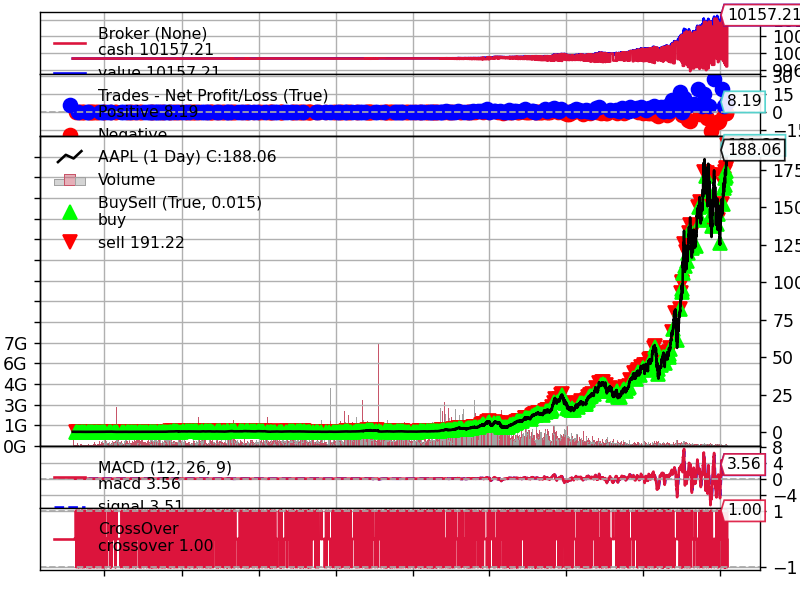

In [2]:
import backtrader as bt
import yfinance as yf

def backtest():
    # Download the data
    data = yf.download('AAPL', start='2020-01-01')

    # Instantiate Cerebro engine
    cerebro = bt.Cerebro()

    # Convert the DataFrame to a Backtrader data feed
    datafeeds = bt.feeds.PandasData(dataname=data)

    # Add data feed to Cerebro
    cerebro.adddata(datafeeds, name='AAPL')

    class MACDStrategy(bt.Strategy):
        params = (
            ('macd1', 12),
            ('macd2', 26),
            ('macdsig', 9),
        )

        def log(self, txt, dt=None):
            dt = dt or self.data.datetime[0]
            dt = bt.num2date(dt)
            print(f'{dt.isoformat()}, {txt}')

        def __init__(self):
            self.macd = bt.indicators.MACD(self.data.close, 
                                           period_me1=self.params.macd1, 
                                           period_me2=self.params.macd2, 
                                           period_signal=self.params.macdsig)

            self.crossover = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)

        def notify_order(self, order):
            if order.status in [order.Submitted, order.Accepted]:
                return

            if order.status in [order.Completed]:
                if order.isbuy():
                    self.log(
                        f'BUY EXECUTED, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Comm {order.executed.comm:.2f}')
                else:  
                    self.log(
                        f'SELL EXECUTED, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Comm {order.executed.comm:.2f}')

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log('Order Canceled/Margin/Rejected')

        def next(self):
            if not self.position: 
                if self.crossover > 0: 
                    self.log('BUY CREATE, %.2f' % self.data.close[0])
                    self.order = self.buy()

            elif self.crossover < 0:  
                self.log('SELL CREATE, %.2f' % self.data.close[0])
                self.order = self.sell()

    # Add strategy
    cerebro.addstrategy(MACDStrategy)

    # Set initial cash
    cerebro.broker.setcash(10000.0)

    # Run the backtest
    test = cerebro.run()

    # Plot the results
    cerebro.plot()

backtest()

### Optimising MACD

In [15]:
# Parameter ranges
macd1_range = range(10, 15)
macd2_range = range(25, 30)
macdsig_range = range(8, 10)

# Run optimization
cerebro.optstrategy(
    MACDStrategy,
    macd1=macd1_range,
    macd2=macd2_range,
    macdsig=macdsig_range
)

In [16]:
# Add an analyzer
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')

# Run Cerebro
results = cerebro.run(maxcpus=1)

# Get optimal parameters
optimal_params = None
highest_total_return = -1

for run in results:
    for res in run:
        total_return = res.analyzers.returns.get_analysis()['rtot']  # total return
        print(f"Total return for params macd1={res.params.macd1}, macd2={res.params.macd2}, macdsig={res.params.macdsig}: {total_return}")
        if total_return > highest_total_return:
            print(f"New highest return found: {total_return}")
            highest_total_return = total_return
            optimal_params = res.params

print(f'Optimal parameters: macd1={optimal_params.macd1}, macd2={optimal_params.macd2}, macdsig={optimal_params.macdsig}')

2020-03-26T00:00:00, BUY CREATE, 64.61
2020-03-26T00:00:00, BUY CREATE, 64.61
2020-03-27T00:00:00, BUY EXECUTED, Price: 63.19, Cost: 63.19, Comm 0.00
2020-03-27T00:00:00, BUY EXECUTED, Price: 63.19, Cost: 63.19, Comm 0.00
2020-05-26T00:00:00, SELL CREATE, 79.18
2020-05-27T00:00:00, SELL CREATE, 79.53
2020-05-27T00:00:00, SELL EXECUTED, Price: 79.04, Cost: 63.19, Comm 0.00
2020-05-28T00:00:00, SELL EXECUTED, Price: 79.19, Cost: 63.19, Comm 0.00
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-26T00:00:00, SELL CREATE, 88.41
2020-06-29T00:00:00, SELL CREATE, 90.44
2020-06-29T00:00:00, SELL EXECUTED, Price: 88.31, Cost: 83.04, Comm 0.00
2020-06-30T00:00:00, SELL EXECUTED, Price: 90.02, Cost: 83.04, Comm 0.00
2020-07-08T00:00:00, BUY CREATE, 95.34
2020-07-08T00:00:00, BUY CREATE, 95.34
2020-07-09T00:00:00, BUY E

2022-02-14T00:00:00, SELL CREATE, 168.88
2022-02-15T00:00:00, SELL EXECUTED, Price: 170.97, Cost: -170.97, Comm 0.00
2022-02-17T00:00:00, SELL CREATE, 168.88
2022-02-17T00:00:00, SELL CREATE, 168.88
2022-02-18T00:00:00, SELL EXECUTED, Price: 169.82, Cost: -169.82, Comm 0.00
2022-02-18T00:00:00, SELL EXECUTED, Price: 169.82, Cost: -169.82, Comm 0.00
2022-04-08T00:00:00, SELL CREATE, 170.09
2022-04-08T00:00:00, SELL CREATE, 170.09
2022-04-11T00:00:00, SELL EXECUTED, Price: 168.71, Cost: -168.71, Comm 0.00
2022-04-11T00:00:00, SELL EXECUTED, Price: 168.71, Cost: -168.71, Comm 0.00
2022-06-13T00:00:00, SELL CREATE, 131.88
2022-06-13T00:00:00, SELL CREATE, 131.88
2022-06-14T00:00:00, SELL EXECUTED, Price: 133.13, Cost: -133.13, Comm 0.00
2022-06-14T00:00:00, SELL EXECUTED, Price: 133.13, Cost: -133.13, Comm 0.00
2022-08-22T00:00:00, SELL CREATE, 167.57
2022-08-22T00:00:00, SELL CREATE, 167.57
2022-08-23T00:00:00, SELL EXECUTED, Price: 167.08, Cost: -167.08, Comm 0.00
2022-08-23T00:00:00, SE

2020-03-26T00:00:00, BUY CREATE, 64.61
2020-03-26T00:00:00, BUY CREATE, 64.61
2020-03-27T00:00:00, BUY EXECUTED, Price: 63.19, Cost: 63.19, Comm 0.00
2020-03-27T00:00:00, BUY EXECUTED, Price: 63.19, Cost: 63.19, Comm 0.00
2020-05-26T00:00:00, SELL CREATE, 79.18
2020-05-27T00:00:00, SELL CREATE, 79.53
2020-05-27T00:00:00, SELL EXECUTED, Price: 79.04, Cost: 63.19, Comm 0.00
2020-05-28T00:00:00, SELL EXECUTED, Price: 79.19, Cost: 63.19, Comm 0.00
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-26T00:00:00, SELL CREATE, 88.41
2020-06-29T00:00:00, SELL CREATE, 90.44
2020-06-29T00:00:00, SELL EXECUTED, Price: 88.31, Cost: 83.04, Comm 0.00
2020-06-30T00:00:00, SELL EXECUTED, Price: 90.02, Cost: 83.04, Comm 0.00
2020-07-08T00:00:00, BUY CREATE, 95.34
2020-07-08T00:00:00, BUY CREATE, 95.34
2020-07-09T00:00:00, BUY E

2021-01-29T00:00:00, SELL CREATE, 131.96
2021-02-01T00:00:00, SELL CREATE, 134.14
2021-02-01T00:00:00, SELL EXECUTED, Price: 133.75, Cost: -133.75, Comm 0.00
2021-02-02T00:00:00, SELL EXECUTED, Price: 135.73, Cost: -135.73, Comm 0.00
2021-04-28T00:00:00, SELL CREATE, 133.58
2021-04-29T00:00:00, SELL CREATE, 133.48
2021-04-29T00:00:00, SELL EXECUTED, Price: 136.47, Cost: -136.47, Comm 0.00
2021-04-30T00:00:00, SELL EXECUTED, Price: 131.78, Cost: -131.78, Comm 0.00
2021-05-28T00:00:00, SELL CREATE, 124.61
2021-06-01T00:00:00, SELL EXECUTED, Price: 125.08, Cost: -125.08, Comm 0.00
2021-07-19T00:00:00, SELL CREATE, 142.45
2021-07-20T00:00:00, SELL EXECUTED, Price: 143.46, Cost: -143.46, Comm 0.00
2021-07-21T00:00:00, SELL CREATE, 145.40
2021-07-22T00:00:00, SELL EXECUTED, Price: 145.94, Cost: -145.94, Comm 0.00
2021-08-18T00:00:00, SELL CREATE, 146.36
2021-08-19T00:00:00, SELL EXECUTED, Price: 145.03, Cost: -145.03, Comm 0.00
2021-09-10T00:00:00, SELL CREATE, 148.97
2021-09-10T00:00:00, SE

2020-03-26T00:00:00, BUY CREATE, 64.61
2020-03-26T00:00:00, BUY CREATE, 64.61
2020-03-27T00:00:00, BUY EXECUTED, Price: 63.19, Cost: 63.19, Comm 0.00
2020-03-27T00:00:00, BUY EXECUTED, Price: 63.19, Cost: 63.19, Comm 0.00
2020-05-26T00:00:00, SELL CREATE, 79.18
2020-05-27T00:00:00, SELL CREATE, 79.53
2020-05-27T00:00:00, SELL EXECUTED, Price: 79.04, Cost: 63.19, Comm 0.00
2020-05-28T00:00:00, SELL EXECUTED, Price: 79.19, Cost: 63.19, Comm 0.00
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-26T00:00:00, SELL CREATE, 88.41
2020-06-29T00:00:00, SELL CREATE, 90.44
2020-06-29T00:00:00, SELL EXECUTED, Price: 88.31, Cost: 83.04, Comm 0.00
2020-06-30T00:00:00, SELL EXECUTED, Price: 90.02, Cost: 83.04, Comm 0.00
2020-07-08T00:00:00, BUY CREATE, 95.34
2020-07-08T00:00:00, BUY CREATE, 95.34
2020-07-09T00:00:00, BUY E

2020-03-26T00:00:00, BUY CREATE, 64.61
2020-03-26T00:00:00, BUY CREATE, 64.61
2020-03-27T00:00:00, BUY EXECUTED, Price: 63.19, Cost: 63.19, Comm 0.00
2020-03-27T00:00:00, BUY EXECUTED, Price: 63.19, Cost: 63.19, Comm 0.00
2020-05-26T00:00:00, SELL CREATE, 79.18
2020-05-27T00:00:00, SELL CREATE, 79.53
2020-05-27T00:00:00, SELL EXECUTED, Price: 79.04, Cost: 63.19, Comm 0.00
2020-05-28T00:00:00, SELL EXECUTED, Price: 79.19, Cost: 63.19, Comm 0.00
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-26T00:00:00, SELL CREATE, 88.41
2020-06-29T00:00:00, SELL CREATE, 90.44
2020-06-29T00:00:00, SELL EXECUTED, Price: 88.31, Cost: 83.04, Comm 0.00
2020-06-30T00:00:00, SELL EXECUTED, Price: 90.02, Cost: 83.04, Comm 0.00
2020-07-07T00:00:00, BUY CREATE, 93.17
2020-07-08T00:00:00, BUY EXECUTED, Price: 94.18, Cost: 94.18, Com

2020-03-26T00:00:00, BUY CREATE, 64.61
2020-03-26T00:00:00, BUY CREATE, 64.61
2020-03-27T00:00:00, BUY EXECUTED, Price: 63.19, Cost: 63.19, Comm 0.00
2020-03-27T00:00:00, BUY EXECUTED, Price: 63.19, Cost: 63.19, Comm 0.00
2020-05-26T00:00:00, SELL CREATE, 79.18
2020-05-27T00:00:00, SELL CREATE, 79.53
2020-05-27T00:00:00, SELL EXECUTED, Price: 79.04, Cost: 63.19, Comm 0.00
2020-05-28T00:00:00, SELL EXECUTED, Price: 79.19, Cost: 63.19, Comm 0.00
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-26T00:00:00, SELL CREATE, 88.41
2020-06-29T00:00:00, SELL CREATE, 90.44
2020-06-29T00:00:00, SELL EXECUTED, Price: 88.31, Cost: 83.04, Comm 0.00
2020-06-30T00:00:00, SELL EXECUTED, Price: 90.02, Cost: 83.04, Comm 0.00
2020-07-08T00:00:00, BUY CREATE, 95.34
2020-07-08T00:00:00, BUY CREATE, 95.34
2020-07-09T00:00:00, BUY E

2020-03-26T00:00:00, BUY CREATE, 64.61
2020-03-26T00:00:00, BUY CREATE, 64.61
2020-03-27T00:00:00, BUY EXECUTED, Price: 63.19, Cost: 63.19, Comm 0.00
2020-03-27T00:00:00, BUY EXECUTED, Price: 63.19, Cost: 63.19, Comm 0.00
2020-05-26T00:00:00, SELL CREATE, 79.18
2020-05-27T00:00:00, SELL CREATE, 79.53
2020-05-27T00:00:00, SELL EXECUTED, Price: 79.04, Cost: 63.19, Comm 0.00
2020-05-28T00:00:00, SELL EXECUTED, Price: 79.19, Cost: 63.19, Comm 0.00
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-26T00:00:00, SELL CREATE, 88.41
2020-06-29T00:00:00, SELL CREATE, 90.44
2020-06-29T00:00:00, SELL EXECUTED, Price: 88.31, Cost: 83.04, Comm 0.00
2020-06-30T00:00:00, SELL EXECUTED, Price: 90.02, Cost: 83.04, Comm 0.00
2020-07-08T00:00:00, BUY CREATE, 95.34
2020-07-08T00:00:00, BUY CREATE, 95.34
2020-07-09T00:00:00, BUY E

2020-05-26T00:00:00, SELL CREATE, 79.18
2020-05-27T00:00:00, SELL CREATE, 79.53
2020-05-27T00:00:00, SELL EXECUTED, Price: 79.04, Cost: 63.19, Comm 0.00
2020-05-28T00:00:00, SELL EXECUTED, Price: 79.19, Cost: 63.19, Comm 0.00
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-26T00:00:00, SELL CREATE, 88.41
2020-06-29T00:00:00, SELL CREATE, 90.44
2020-06-29T00:00:00, SELL EXECUTED, Price: 88.31, Cost: 83.04, Comm 0.00
2020-06-30T00:00:00, SELL EXECUTED, Price: 90.02, Cost: 83.04, Comm 0.00
2020-07-08T00:00:00, BUY CREATE, 95.34
2020-07-08T00:00:00, BUY CREATE, 95.34
2020-07-09T00:00:00, BUY EXECUTED, Price: 96.26, Cost: 96.26, Comm 0.00
2020-07-09T00:00:00, BUY EXECUTED, Price: 96.26, Cost: 96.26, Comm 0.00
2020-07-17T00:00:00, SELL CREATE, 96.33
2020-07-17T00:00:00, SELL CREATE, 96.33
2020-07-20T00:00:00, SEL

2020-03-27T00:00:00, BUY EXECUTED, Price: 63.19, Cost: 63.19, Comm 0.00
2020-03-27T00:00:00, BUY EXECUTED, Price: 63.19, Cost: 63.19, Comm 0.00
2020-05-27T00:00:00, SELL CREATE, 79.53
2020-05-27T00:00:00, SELL CREATE, 79.53
2020-05-28T00:00:00, SELL EXECUTED, Price: 79.19, Cost: 63.19, Comm 0.00
2020-05-28T00:00:00, SELL EXECUTED, Price: 79.19, Cost: 63.19, Comm 0.00
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-26T00:00:00, SELL CREATE, 88.41
2020-06-29T00:00:00, SELL CREATE, 90.44
2020-06-29T00:00:00, SELL EXECUTED, Price: 88.31, Cost: 83.04, Comm 0.00
2020-06-30T00:00:00, SELL EXECUTED, Price: 90.02, Cost: 83.04, Comm 0.00
2020-07-08T00:00:00, BUY CREATE, 95.34
2020-07-08T00:00:00, BUY CREATE, 95.34
2020-07-09T00:00:00, BUY EXECUTED, Price: 96.26, Cost: 96.26, Comm 0.00
2020-07-09T00:00:00, BUY EXECUTE

2020-03-27T00:00:00, BUY EXECUTED, Price: 63.19, Cost: 63.19, Comm 0.00
2020-05-27T00:00:00, SELL CREATE, 79.53
2020-05-27T00:00:00, SELL CREATE, 79.53
2020-05-28T00:00:00, SELL EXECUTED, Price: 79.19, Cost: 63.19, Comm 0.00
2020-05-28T00:00:00, SELL EXECUTED, Price: 79.19, Cost: 63.19, Comm 0.00
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-26T00:00:00, SELL CREATE, 88.41
2020-06-29T00:00:00, SELL CREATE, 90.44
2020-06-29T00:00:00, SELL EXECUTED, Price: 88.31, Cost: 83.04, Comm 0.00
2020-06-30T00:00:00, SELL EXECUTED, Price: 90.02, Cost: 83.04, Comm 0.00
2020-07-07T00:00:00, BUY CREATE, 93.17
2020-07-08T00:00:00, BUY EXECUTED, Price: 94.18, Cost: 94.18, Comm 0.00
2020-07-17T00:00:00, SELL CREATE, 96.33
2020-07-17T00:00:00, SELL CREATE, 96.33
2020-07-20T00:00:00, SELL EXECUTED, Price: 96.42, Cost: 94.18, 

2020-05-26T00:00:00, SELL CREATE, 79.18
2020-05-27T00:00:00, SELL CREATE, 79.53
2020-05-27T00:00:00, SELL EXECUTED, Price: 79.04, Cost: 63.19, Comm 0.00
2020-05-28T00:00:00, SELL EXECUTED, Price: 79.19, Cost: 63.19, Comm 0.00
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-26T00:00:00, SELL CREATE, 88.41
2020-06-29T00:00:00, SELL CREATE, 90.44
2020-06-29T00:00:00, SELL EXECUTED, Price: 88.31, Cost: 83.04, Comm 0.00
2020-06-30T00:00:00, SELL EXECUTED, Price: 90.02, Cost: 83.04, Comm 0.00
2020-07-08T00:00:00, BUY CREATE, 95.34
2020-07-08T00:00:00, BUY CREATE, 95.34
2020-07-09T00:00:00, BUY EXECUTED, Price: 96.26, Cost: 96.26, Comm 0.00
2020-07-09T00:00:00, BUY EXECUTED, Price: 96.26, Cost: 96.26, Comm 0.00
2020-07-17T00:00:00, SELL CREATE, 96.33
2020-07-17T00:00:00, SELL CREATE, 96.33
2020-07-20T00:00:00, SEL

2020-03-26T00:00:00, BUY CREATE, 64.61
2020-03-26T00:00:00, BUY CREATE, 64.61
2020-03-27T00:00:00, BUY EXECUTED, Price: 63.19, Cost: 63.19, Comm 0.00
2020-03-27T00:00:00, BUY EXECUTED, Price: 63.19, Cost: 63.19, Comm 0.00
2020-05-27T00:00:00, SELL CREATE, 79.53
2020-05-27T00:00:00, SELL CREATE, 79.53
2020-05-28T00:00:00, SELL EXECUTED, Price: 79.19, Cost: 63.19, Comm 0.00
2020-05-28T00:00:00, SELL EXECUTED, Price: 79.19, Cost: 63.19, Comm 0.00
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-26T00:00:00, SELL CREATE, 88.41
2020-06-29T00:00:00, SELL CREATE, 90.44
2020-06-29T00:00:00, SELL EXECUTED, Price: 88.31, Cost: 83.04, Comm 0.00
2020-06-30T00:00:00, SELL EXECUTED, Price: 90.02, Cost: 83.04, Comm 0.00
2020-07-08T00:00:00, BUY CREATE, 95.34
2020-07-08T00:00:00, BUY CREATE, 95.34
2020-07-09T00:00:00, BUY E

2020-03-26T00:00:00, BUY CREATE, 64.61
2020-03-26T00:00:00, BUY CREATE, 64.61
2020-03-27T00:00:00, BUY EXECUTED, Price: 63.19, Cost: 63.19, Comm 0.00
2020-03-27T00:00:00, BUY EXECUTED, Price: 63.19, Cost: 63.19, Comm 0.00
2020-05-27T00:00:00, SELL CREATE, 79.53
2020-05-27T00:00:00, SELL CREATE, 79.53
2020-05-28T00:00:00, SELL EXECUTED, Price: 79.19, Cost: 63.19, Comm 0.00
2020-05-28T00:00:00, SELL EXECUTED, Price: 79.19, Cost: 63.19, Comm 0.00
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-26T00:00:00, SELL CREATE, 88.41
2020-06-29T00:00:00, SELL CREATE, 90.44
2020-06-29T00:00:00, SELL EXECUTED, Price: 88.31, Cost: 83.04, Comm 0.00
2020-06-30T00:00:00, SELL EXECUTED, Price: 90.02, Cost: 83.04, Comm 0.00
2020-07-08T00:00:00, BUY CREATE, 95.34
2020-07-08T00:00:00, BUY CREATE, 95.34
2020-07-09T00:00:00, BUY E

2020-05-27T00:00:00, SELL CREATE, 79.53
2020-05-27T00:00:00, SELL CREATE, 79.53
2020-05-28T00:00:00, SELL EXECUTED, Price: 79.19, Cost: 63.19, Comm 0.00
2020-05-28T00:00:00, SELL EXECUTED, Price: 79.19, Cost: 63.19, Comm 0.00
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-29T00:00:00, SELL CREATE, 90.44
2020-06-29T00:00:00, SELL CREATE, 90.44
2020-06-30T00:00:00, SELL EXECUTED, Price: 90.02, Cost: 83.04, Comm 0.00
2020-06-30T00:00:00, SELL EXECUTED, Price: 90.02, Cost: 83.04, Comm 0.00
2020-07-07T00:00:00, BUY CREATE, 93.17
2020-07-08T00:00:00, BUY EXECUTED, Price: 94.18, Cost: 94.18, Comm 0.00
2020-07-17T00:00:00, SELL CREATE, 96.33
2020-07-17T00:00:00, SELL CREATE, 96.33
2020-07-20T00:00:00, SELL EXECUTED, Price: 96.42, Cost: 94.18, Comm 0.00
2020-07-20T00:00:00, SELL EXECUTED, Price: 96.42, Cost: -96.42

2020-09-03T00:00:00, SELL CREATE, 120.88
2020-09-03T00:00:00, SELL CREATE, 120.88
2020-09-04T00:00:00, SELL EXECUTED, Price: 120.07, Cost: -120.07, Comm 0.00
2020-09-04T00:00:00, SELL EXECUTED, Price: 120.07, Cost: -120.07, Comm 0.00
2020-10-21T00:00:00, SELL CREATE, 116.87
2020-10-21T00:00:00, SELL CREATE, 116.87
2020-10-22T00:00:00, SELL EXECUTED, Price: 117.45, Cost: -117.45, Comm 0.00
2020-10-22T00:00:00, SELL EXECUTED, Price: 117.45, Cost: -117.45, Comm 0.00
2020-11-23T00:00:00, SELL CREATE, 113.85
2020-11-23T00:00:00, SELL CREATE, 113.85
2020-11-24T00:00:00, SELL EXECUTED, Price: 113.91, Cost: -113.91, Comm 0.00
2020-11-24T00:00:00, SELL EXECUTED, Price: 113.91, Cost: -113.91, Comm 0.00
2021-01-05T00:00:00, SELL CREATE, 131.01
2021-01-05T00:00:00, SELL CREATE, 131.01
2021-01-06T00:00:00, SELL EXECUTED, Price: 127.72, Cost: -127.72, Comm 0.00
2021-01-06T00:00:00, SELL EXECUTED, Price: 127.72, Cost: -127.72, Comm 0.00
2021-02-01T00:00:00, SELL CREATE, 134.14
2021-02-01T00:00:00, SE

2021-02-01T00:00:00, SELL CREATE, 134.14
2021-02-01T00:00:00, SELL CREATE, 134.14
2021-02-02T00:00:00, SELL EXECUTED, Price: 135.73, Cost: -135.73, Comm 0.00
2021-02-02T00:00:00, SELL EXECUTED, Price: 135.73, Cost: -135.73, Comm 0.00
2021-04-29T00:00:00, SELL CREATE, 133.48
2021-04-29T00:00:00, SELL CREATE, 133.48
2021-04-30T00:00:00, SELL EXECUTED, Price: 131.78, Cost: -131.78, Comm 0.00
2021-04-30T00:00:00, SELL EXECUTED, Price: 131.78, Cost: -131.78, Comm 0.00
2021-07-21T00:00:00, SELL CREATE, 145.40
2021-07-21T00:00:00, SELL CREATE, 145.40
2021-07-22T00:00:00, SELL EXECUTED, Price: 145.94, Cost: -145.94, Comm 0.00
2021-07-22T00:00:00, SELL EXECUTED, Price: 145.94, Cost: -145.94, Comm 0.00
2021-08-18T00:00:00, SELL CREATE, 146.36
2021-08-19T00:00:00, SELL EXECUTED, Price: 145.03, Cost: -145.03, Comm 0.00
2021-09-10T00:00:00, SELL CREATE, 148.97
2021-09-10T00:00:00, SELL CREATE, 148.97
2021-09-13T00:00:00, SELL EXECUTED, Price: 150.63, Cost: -150.63, Comm 0.00
2021-09-13T00:00:00, SE

2021-01-06T00:00:00, SELL EXECUTED, Price: 127.72, Cost: -127.72, Comm 0.00
2021-02-01T00:00:00, SELL CREATE, 134.14
2021-02-01T00:00:00, SELL CREATE, 134.14
2021-02-02T00:00:00, SELL EXECUTED, Price: 135.73, Cost: -135.73, Comm 0.00
2021-02-02T00:00:00, SELL EXECUTED, Price: 135.73, Cost: -135.73, Comm 0.00
2021-04-29T00:00:00, SELL CREATE, 133.48
2021-04-29T00:00:00, SELL CREATE, 133.48
2021-04-30T00:00:00, SELL EXECUTED, Price: 131.78, Cost: -131.78, Comm 0.00
2021-04-30T00:00:00, SELL EXECUTED, Price: 131.78, Cost: -131.78, Comm 0.00
2021-07-21T00:00:00, SELL CREATE, 145.40
2021-07-21T00:00:00, SELL CREATE, 145.40
2021-07-22T00:00:00, SELL EXECUTED, Price: 145.94, Cost: -145.94, Comm 0.00
2021-07-22T00:00:00, SELL EXECUTED, Price: 145.94, Cost: -145.94, Comm 0.00
2021-08-18T00:00:00, SELL CREATE, 146.36
2021-08-19T00:00:00, SELL EXECUTED, Price: 145.03, Cost: -145.03, Comm 0.00
2021-09-10T00:00:00, SELL CREATE, 148.97
2021-09-10T00:00:00, SELL CREATE, 148.97
2021-09-13T00:00:00, SE

2021-01-05T00:00:00, SELL CREATE, 131.01
2021-01-05T00:00:00, SELL CREATE, 131.01
2021-01-06T00:00:00, SELL EXECUTED, Price: 127.72, Cost: -127.72, Comm 0.00
2021-01-06T00:00:00, SELL EXECUTED, Price: 127.72, Cost: -127.72, Comm 0.00
2021-02-01T00:00:00, SELL CREATE, 134.14
2021-02-01T00:00:00, SELL CREATE, 134.14
2021-02-02T00:00:00, SELL EXECUTED, Price: 135.73, Cost: -135.73, Comm 0.00
2021-02-02T00:00:00, SELL EXECUTED, Price: 135.73, Cost: -135.73, Comm 0.00
2021-04-29T00:00:00, SELL CREATE, 133.48
2021-04-29T00:00:00, SELL CREATE, 133.48
2021-04-30T00:00:00, SELL EXECUTED, Price: 131.78, Cost: -131.78, Comm 0.00
2021-04-30T00:00:00, SELL EXECUTED, Price: 131.78, Cost: -131.78, Comm 0.00
2021-07-21T00:00:00, SELL CREATE, 145.40
2021-07-21T00:00:00, SELL CREATE, 145.40
2021-07-22T00:00:00, SELL EXECUTED, Price: 145.94, Cost: -145.94, Comm 0.00
2021-07-22T00:00:00, SELL EXECUTED, Price: 145.94, Cost: -145.94, Comm 0.00
2021-09-10T00:00:00, SELL CREATE, 148.97
2021-09-10T00:00:00, SE

2021-02-01T00:00:00, SELL CREATE, 134.14
2021-02-01T00:00:00, SELL CREATE, 134.14
2021-02-02T00:00:00, SELL EXECUTED, Price: 135.73, Cost: -135.73, Comm 0.00
2021-02-02T00:00:00, SELL EXECUTED, Price: 135.73, Cost: -135.73, Comm 0.00
2021-04-29T00:00:00, SELL CREATE, 133.48
2021-04-29T00:00:00, SELL CREATE, 133.48
2021-04-30T00:00:00, SELL EXECUTED, Price: 131.78, Cost: -131.78, Comm 0.00
2021-04-30T00:00:00, SELL EXECUTED, Price: 131.78, Cost: -131.78, Comm 0.00
2021-07-21T00:00:00, SELL CREATE, 145.40
2021-07-21T00:00:00, SELL CREATE, 145.40
2021-07-22T00:00:00, SELL EXECUTED, Price: 145.94, Cost: -145.94, Comm 0.00
2021-07-22T00:00:00, SELL EXECUTED, Price: 145.94, Cost: -145.94, Comm 0.00
2021-09-10T00:00:00, SELL CREATE, 148.97
2021-09-10T00:00:00, SELL CREATE, 148.97
2021-09-13T00:00:00, SELL EXECUTED, Price: 150.63, Cost: -150.63, Comm 0.00
2021-09-13T00:00:00, SELL EXECUTED, Price: 150.63, Cost: -150.63, Comm 0.00
2021-11-10T00:00:00, SELL CREATE, 147.92
2021-11-10T00:00:00, SE

2021-04-29T00:00:00, SELL CREATE, 133.48
2021-04-29T00:00:00, SELL CREATE, 133.48
2021-04-30T00:00:00, SELL EXECUTED, Price: 131.78, Cost: -131.78, Comm 0.00
2021-04-30T00:00:00, SELL EXECUTED, Price: 131.78, Cost: -131.78, Comm 0.00
2021-07-21T00:00:00, SELL CREATE, 145.40
2021-07-21T00:00:00, SELL CREATE, 145.40
2021-07-22T00:00:00, SELL EXECUTED, Price: 145.94, Cost: -145.94, Comm 0.00
2021-07-22T00:00:00, SELL EXECUTED, Price: 145.94, Cost: -145.94, Comm 0.00
2021-09-10T00:00:00, SELL CREATE, 148.97
2021-09-10T00:00:00, SELL CREATE, 148.97
2021-09-13T00:00:00, SELL EXECUTED, Price: 150.63, Cost: -150.63, Comm 0.00
2021-09-13T00:00:00, SELL EXECUTED, Price: 150.63, Cost: -150.63, Comm 0.00
2021-11-10T00:00:00, SELL CREATE, 147.92
2021-11-10T00:00:00, SELL CREATE, 147.92
2021-11-11T00:00:00, SELL EXECUTED, Price: 148.96, Cost: -148.96, Comm 0.00
2021-11-11T00:00:00, SELL EXECUTED, Price: 148.96, Cost: -148.96, Comm 0.00
2021-12-17T00:00:00, SELL CREATE, 171.14
2021-12-20T00:00:00, SE

2021-03-15T00:00:00, BUY CREATE, 123.99
2021-03-15T00:00:00, BUY CREATE, 123.99
2021-03-16T00:00:00, BUY EXECUTED, Price: 125.70, Cost: 125.70, Comm 0.00
2021-03-16T00:00:00, BUY EXECUTED, Price: 125.70, Cost: 125.70, Comm 0.00
2021-04-29T00:00:00, SELL CREATE, 133.48
2021-04-29T00:00:00, SELL CREATE, 133.48
2021-04-30T00:00:00, SELL EXECUTED, Price: 131.78, Cost: 125.70, Comm 0.00
2021-04-30T00:00:00, SELL EXECUTED, Price: 131.78, Cost: 125.70, Comm 0.00
2021-06-07T00:00:00, BUY CREATE, 125.90
2021-06-07T00:00:00, BUY CREATE, 125.90
2021-06-08T00:00:00, BUY EXECUTED, Price: 126.60, Cost: 126.60, Comm 0.00
2021-06-08T00:00:00, BUY EXECUTED, Price: 126.60, Cost: 126.60, Comm 0.00
2021-07-21T00:00:00, SELL CREATE, 145.40
2021-07-21T00:00:00, SELL CREATE, 145.40
2021-07-22T00:00:00, SELL EXECUTED, Price: 145.94, Cost: 126.60, Comm 0.00
2021-07-22T00:00:00, SELL EXECUTED, Price: 145.94, Cost: 126.60, Comm 0.00
2021-08-31T00:00:00, BUY CREATE, 151.83
2021-08-31T00:00:00, BUY CREATE, 151.83


2020-03-26T00:00:00, BUY CREATE, 64.61
2020-03-27T00:00:00, BUY EXECUTED, Price: 63.19, Cost: 63.19, Comm 0.00
2020-05-27T00:00:00, SELL CREATE, 79.53
2020-05-27T00:00:00, SELL CREATE, 79.53
2020-05-28T00:00:00, SELL EXECUTED, Price: 79.19, Cost: 63.19, Comm 0.00
2020-05-28T00:00:00, SELL EXECUTED, Price: 79.19, Cost: -79.19, Comm 0.00
2020-06-29T00:00:00, SELL CREATE, 90.44
2020-06-29T00:00:00, SELL CREATE, 90.44
2020-06-30T00:00:00, SELL EXECUTED, Price: 90.02, Cost: -90.02, Comm 0.00
2020-06-30T00:00:00, SELL EXECUTED, Price: 90.02, Cost: -90.02, Comm 0.00
2020-07-17T00:00:00, SELL CREATE, 96.33
2020-07-17T00:00:00, SELL CREATE, 96.33
2020-07-20T00:00:00, SELL EXECUTED, Price: 96.42, Cost: -96.42, Comm 0.00
2020-07-20T00:00:00, SELL EXECUTED, Price: 96.42, Cost: -96.42, Comm 0.00
2020-07-21T00:00:00, SELL CREATE, 97.00
2020-07-21T00:00:00, SELL CREATE, 97.00
2020-07-22T00:00:00, SELL EXECUTED, Price: 96.69, Cost: -96.69, Comm 0.00
2020-07-22T00:00:00, SELL EXECUTED, Price: 96.69, Co

2020-05-27T00:00:00, SELL CREATE, 79.53
2020-05-28T00:00:00, SELL EXECUTED, Price: 79.19, Cost: 63.19, Comm 0.00
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-29T00:00:00, SELL CREATE, 90.44
2020-06-29T00:00:00, SELL CREATE, 90.44
2020-06-30T00:00:00, SELL EXECUTED, Price: 90.02, Cost: 83.04, Comm 0.00
2020-06-30T00:00:00, SELL EXECUTED, Price: 90.02, Cost: 83.04, Comm 0.00
2020-07-07T00:00:00, BUY CREATE, 93.17
2020-07-08T00:00:00, BUY EXECUTED, Price: 94.18, Cost: 94.18, Comm 0.00
2020-07-17T00:00:00, SELL CREATE, 96.33
2020-07-17T00:00:00, SELL CREATE, 96.33
2020-07-20T00:00:00, SELL EXECUTED, Price: 96.42, Cost: 94.18, Comm 0.00
2020-07-20T00:00:00, SELL EXECUTED, Price: 96.42, Cost: -96.42, Comm 0.00
2020-07-21T00:00:00, SELL CREATE, 97.00
2020-07-21T00:00:00, SELL CREATE, 97.00
2020-07-22T00:00:00, 

2020-03-26T00:00:00, BUY CREATE, 64.61
2020-03-27T00:00:00, BUY EXECUTED, Price: 63.19, Cost: 63.19, Comm 0.00
2020-05-27T00:00:00, SELL CREATE, 79.53
2020-05-28T00:00:00, SELL EXECUTED, Price: 79.19, Cost: 63.19, Comm 0.00
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-29T00:00:00, SELL CREATE, 90.44
2020-06-29T00:00:00, SELL CREATE, 90.44
2020-06-30T00:00:00, SELL EXECUTED, Price: 90.02, Cost: 83.04, Comm 0.00
2020-06-30T00:00:00, SELL EXECUTED, Price: 90.02, Cost: 83.04, Comm 0.00
2020-07-07T00:00:00, BUY CREATE, 93.17
2020-07-08T00:00:00, BUY EXECUTED, Price: 94.18, Cost: 94.18, Comm 0.00
2020-07-17T00:00:00, SELL CREATE, 96.33
2020-07-17T00:00:00, SELL CREATE, 96.33
2020-07-20T00:00:00, SELL EXECUTED, Price: 96.42, Cost: 94.18, Comm 0.00
2020-07-20T00:00:00, SELL EXECUTED, Price: 96.42, Cost: -96.42, 

2020-03-26T00:00:00, BUY CREATE, 64.61
2020-03-27T00:00:00, BUY EXECUTED, Price: 63.19, Cost: 63.19, Comm 0.00
2020-05-27T00:00:00, SELL CREATE, 79.53
2020-05-28T00:00:00, SELL EXECUTED, Price: 79.19, Cost: 63.19, Comm 0.00
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.00
2020-06-29T00:00:00, SELL CREATE, 90.44
2020-06-29T00:00:00, SELL CREATE, 90.44
2020-06-30T00:00:00, SELL EXECUTED, Price: 90.02, Cost: 83.04, Comm 0.00
2020-06-30T00:00:00, SELL EXECUTED, Price: 90.02, Cost: 83.04, Comm 0.00
2020-07-07T00:00:00, BUY CREATE, 93.17
2020-07-08T00:00:00, BUY EXECUTED, Price: 94.18, Cost: 94.18, Comm 0.00
2020-07-17T00:00:00, SELL CREATE, 96.33
2020-07-17T00:00:00, SELL CREATE, 96.33
2020-07-20T00:00:00, SELL EXECUTED, Price: 96.42, Cost: 94.18, Comm 0.00
2020-07-20T00:00:00, SELL EXECUTED, Price: 96.42, Cost: -96.42, 

## RSI

In [23]:
# Instantiate Cerebro engine
cerebro = bt.Cerebro()

# Convert the DataFrame to a Backtrader data feed and store it in the dictionary
datafeeds = bt.feeds.PandasData(dataname=data)

cerebro.adddata(datafeeds, name='AAPL')

class RSIStrategy(bt.Strategy):
    params = (
        ('rsi_period', 14),
        ('rsi_lower', 30),
        ('rsi_upper', 70),
    )

    def log(self, txt, dt=None):
        dt = dt or self.data.datetime[0]
        dt = bt.num2date(dt)
        print(f'{dt.isoformat()}, {txt}')

    def __init__(self):
        self.rsi = bt.indicators.RSI_SMA(
            self.data.close, period=self.params.rsi_period)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    f'BUY EXECUTED, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Comm {order.executed.comm:.2f}')
            else:  # Sell
                self.log(
                    f'SELL EXECUTED, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Comm {order.executed.comm:.2f}')

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

    def next(self):
        if not self.position:  # not in the market
            if self.rsi < self.params.rsi_lower:  
                self.log('BUY CREATE, %.2f' % self.data.close[0])
                self.order = self.buy()  # enter long

        else:  # in the market
            if self.rsi > self.params.rsi_upper:
                self.log('SELL CREATE, %.2f' % self.data.close[0])
                self.order = self.sell()  # close long position

In [24]:
# Add strategy
cerebro.addstrategy(RSIStrategy)
cerebro.broker.setcash(10000.0)

In [25]:
# Run the backtest
res = cerebro.run()

2020-02-25T00:00:00, BUY CREATE, 72.02
2020-02-26T00:00:00, BUY EXECUTED, Price: 71.63, Cost: 71.63, Comm 0.00
2020-04-13T00:00:00, SELL CREATE, 68.31
2020-04-14T00:00:00, SELL EXECUTED, Price: 70.00, Cost: 71.63, Comm 0.00
2020-09-22T00:00:00, BUY CREATE, 111.81
2020-09-23T00:00:00, BUY EXECUTED, Price: 111.62, Cost: 111.62, Comm 0.00
2020-11-19T00:00:00, SELL CREATE, 118.64
2020-11-20T00:00:00, SELL EXECUTED, Price: 118.64, Cost: 111.62, Comm 0.00
2021-02-16T00:00:00, BUY CREATE, 133.19
2021-02-17T00:00:00, BUY EXECUTED, Price: 131.25, Cost: 131.25, Comm 0.00
2021-04-08T00:00:00, SELL CREATE, 130.36
2021-04-09T00:00:00, SELL EXECUTED, Price: 129.80, Cost: 131.25, Comm 0.00
2021-05-12T00:00:00, BUY CREATE, 122.77
2021-05-13T00:00:00, BUY EXECUTED, Price: 124.58, Cost: 124.58, Comm 0.00
2021-06-17T00:00:00, SELL CREATE, 131.79
2021-06-18T00:00:00, SELL EXECUTED, Price: 130.71, Cost: 124.58, Comm 0.00
2021-09-20T00:00:00, BUY CREATE, 142.94
2021-09-21T00:00:00, BUY EXECUTED, Price: 143.

In [26]:
cerebro.plot()

[[<Figure size 640x480 with 5 Axes>]]

### Opimising RSI

In [27]:
# Parameter ranges
rsi_period_range = range(10, 15)
rsi_lower_range = range(20, 30)
rsi_upper_range = range(70, 80)

# Run optimization
cerebro.optstrategy(
    RSIStrategy,
    rsi_period=rsi_period_range,
    rsi_lower=rsi_lower_range,
    rsi_upper=rsi_upper_range
)

In [16]:
# # Add an analyzer
# cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')

# # Run Cerebro
# results = cerebro.run(maxcpus=1)

# # Get optimal parameters
# optimal_params = None
# highest_total_return = -1

# for run in results:
#     for res in run:
#         total_return = res.analyzers.returns.get_analysis()['rtot']  # total return
#         print(f"Total return for params rsi_period={res.params.rsi_period}, rsi_lower={res.params.rsi_lower}, rsi_upper={res.params.rsi_upper}: {total_return}")
#         if total_return > highest_total_return:
#             print(f"New highest return found: {total_return}")
#             highest_total_return = total_return
#             optimal_params = res.params

# print(f'Optimal parameters: rsi_period={optimal_params.rsi_period}, rsi_lower={optimal_params.rsi_lower}, rsi_upper={optimal_params.rsi_upper}')

# Combining the Strategies Together

Backtesting AMZN...
[*********************100%***********************]  1 of 1 completed
2020-03-23T00:00:00, BUY CREATE, 95.14
2020-03-24T00:00:00, BUY EXECUTED, Price: 97.57, Cost: 97.57, Comm 0.98
2020-05-01T00:00:00, SELL CREATE, 114.30
2020-05-04T00:00:00, SELL EXECUTED, Price: 112.82, Cost: 97.57, Comm 1.13
2020-06-09T00:00:00, BUY CREATE, 130.04
2020-06-10T00:00:00, BUY EXECUTED, Price: 132.25, Cost: 132.25, Comm 1.32
2020-07-16T00:00:00, SELL CREATE, 149.99
2020-07-17T00:00:00, SELL EXECUTED, Price: 150.45, Cost: 132.25, Comm 1.50
2020-08-19T00:00:00, BUY CREATE, 163.02
2020-08-20T00:00:00, BUY EXECUTED, Price: 162.60, Cost: 162.60, Comm 1.63
2020-09-04T00:00:00, SELL CREATE, 164.73
2020-09-08T00:00:00, SELL EXECUTED, Price: 157.20, Cost: 162.60, Comm 1.57
2020-09-29T00:00:00, BUY CREATE, 157.24
2020-09-30T00:00:00, BUY EXECUTED, Price: 157.06, Cost: 157.06, Comm 1.57
2020-10-21T00:00:00, SELL CREATE, 159.25
2020-10-22T00:00:00, SELL EXECUTED, Price: 159.49, Cost: 157.06, Comm 

<IPython.core.display.Javascript object>


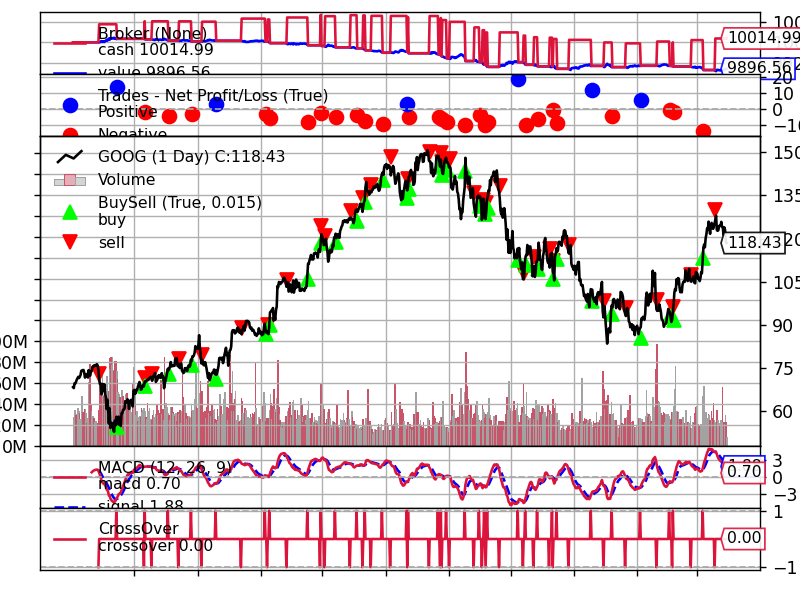

Backtesting AAPL...
[*********************100%***********************]  1 of 1 completed
2020-03-26T00:00:00, BUY CREATE, 64.61
2020-03-27T00:00:00, BUY EXECUTED, Price: 63.19, Cost: 63.19, Comm 0.63
2020-05-27T00:00:00, SELL CREATE, 79.53
2020-05-28T00:00:00, SELL EXECUTED, Price: 79.19, Cost: 63.19, Comm 0.79
2020-06-08T00:00:00, BUY CREATE, 83.36
2020-06-09T00:00:00, BUY EXECUTED, Price: 83.04, Cost: 83.04, Comm 0.83
2020-06-29T00:00:00, SELL CREATE, 90.44
2020-06-30T00:00:00, SELL EXECUTED, Price: 90.02, Cost: 83.04, Comm 0.90
2020-07-08T00:00:00, BUY CREATE, 95.34
2020-07-09T00:00:00, BUY EXECUTED, Price: 96.26, Cost: 96.26, Comm 0.96
2020-07-17T00:00:00, SELL CREATE, 96.33
2020-07-20T00:00:00, SELL EXECUTED, Price: 96.42, Cost: 96.26, Comm 0.96
2020-07-20T00:00:00, BUY CREATE, 98.36
2020-07-21T00:00:00, BUY EXECUTED, Price: 99.17, Cost: 99.17, Comm 0.99
2020-07-21T00:00:00, SELL CREATE, 97.00
2020-07-22T00:00:00, SELL EXECUTED, Price: 96.69, Cost: 99.17, Comm 0.97
2020-07-31T00:0

In [2]:
import backtrader as bt
import yfinance as yf
import pandas as pd
import os

# Define MACDStrategy class
class Strategy(bt.Strategy):
    """
    This class defines a trading strategy using MACD as a signal and considering a primary signal from a DataFrame.
    """
    params = (
        ('macd1', 12),
        ('macd2', 26),
        ('macdsig', 9),
        ('df', None),  # add DataFrame as a parameter
    )

    def log(self, txt, dt=None):
        dt = dt or self.data.datetime[0]
        dt = bt.num2date(dt)
        print(f'{dt.isoformat()}, {txt}')

    def __init__(self):
        self.macd = bt.indicators.MACD(self.data.close,
                                       period_me1=self.params.macd1,
                                       period_me2=self.params.macd2,
                                       period_signal=self.params.macdsig)
        self.crossover = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    f'BUY EXECUTED, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Comm {order.executed.comm:.2f}')
            else:
                self.log(
                    f'SELL EXECUTED, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Comm {order.executed.comm:.2f}')
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

    def next(self):
        signal = self.params.df.loc[self.params.df['Ticker'] == self.data._name, 'Signal'].values[0]

        if not self.position:
            if self.crossover > 0 and signal == 'Buy':
                self.log('BUY CREATE, %.2f' % self.data.close[0])
                self.order = self.buy()
            elif self.crossover < 0 and signal == 'Sell':
                self.log('SELL CREATE, %.2f' % self.data.close[0])
                self.order = self.sell()

        else:
            if self.crossover < 0 and signal == 'Buy':
                self.log('SELL CREATE, %.2f' % self.data.close[0])
                self.order = self.sell()
            elif self.crossover > 0 and signal == 'Sell':
                self.log('BUY CREATE, %.2f' % self.data.close[0])
                self.order = self.buy()


def run_backtest(df):
    """
    This function performs backtesting on multiple stocks based on the MACDStrategy and a primary signal from a DataFrame.
    """
    initial_cash = 10000.0  # Initial cash
    
    # Loop over all rows in the DataFrame
    for index, row in df.iterrows():
        ticker = row['Ticker']
        signal = row['Signal']
        
        # Skip this ticker if signal is 'Hold'
        if signal == 'Hold':
            continue

        print(f'Backtesting {ticker}...')  # Log the ticker currently being backtested
        
        # Download the data
        data = yf.download(ticker, start='2020-01-01')

        # Instantiate Cerebro engine
        cerebro = bt.Cerebro()

        # Convert the DataFrame to a Backtrader data feed
        datafeeds = bt.feeds.PandasData(dataname=data)

        # Add data feed to Cerebro
        cerebro.adddata(datafeeds, name=ticker)

        # Add strategy and pass DataFrame as a parameter
        cerebro.addstrategy(Strategy, df=df)

        # Set commission and initial cash
        cerebro.broker.setcommission(commission=0.01)  # 1% commission
        cerebro.broker.setcash(initial_cash)

        # Run the backtest
        test = cerebro.run()

        # Calculate percentage return
        final_portfolio_value = cerebro.broker.getvalue()
        perc_return = (final_portfolio_value - initial_cash) / initial_cash * 100

        # Print out final portfolio value and the percentage return
        print(f'Final portfolio value for {ticker}: {cerebro.broker.getvalue():.2f}')
        print(f'Return for {ticker}: {perc_return:.2f}%')


data_path = '/home/adedapo/personal_project/daps05ayoade/disseration/algotrading/output'
final_df = pd.read_excel(os.path.join(data_path, 'Testing Strategy.xlsx'))
run_backtest(final_df)